### **1. Introduction & Recap**

In **Notebook 3**, we explored **transfer learning** by adapting a pretrained **ResNet18** (trained on ImageNet) for the **Plant Seedlings** dataset. This approach significantly improved performance compared to the custom CNN trained from scratch in **Notebook 2**.

**Where We Left Off (Quick Comparison)**

| Model               | Parameters (Trainable) | Test Accuracy |
|---------------------|------------------------|---------------|
| Scratch CNN (NB02)  | ~25.7M (all layers)    | ~68%          |
| ResNet18 TL (NB03)  | ~6K (classifier only)  | ~78%       |

**Key insight:**  
Pretrained models learn **generic visual features** (edges → textures → shapes) from ImageNet, which transfer well to plant seedling classification — even though seedlings are visually different from typical ImageNet objects.

**Why Data Augmentation Now?**

Despite the accuracy boost, we still face challenges:

- **Overfitting signs:** Validation accuracy plateaued while training accuracy kept rising.  
- **Class imbalance:** Some species (e.g., *Black-grass*) remain underrepresented → prone to misclassification.  
- **Environmental noise:** Background soil, lighting variations, and overlapping seedlings introduce variability.

**Data augmentation** helps by artificially increasing dataset diversity:
- Random flips, rotations, and color adjustments simulate real-world variability.
- Forces model to learn **robust features** rather than memorizing pixel patterns.

**Goals of This Notebook**

1. Introduce common augmentation techniques using `torchvision.transforms`.
2. Retrain ResNet18 with augmented data and compare results to baseline ResNet18.
3. Evaluate improvements in **generalization** (test accuracy, per-class metrics).
4. Discuss **robustness and deployment considerations** for real-world seedling recognition.

---


### **2. Augmentation Strategies (Theory)**

**Why Data Augmentation?**

Data augmentation artificially **expands the training dataset** by applying random transformations to existing images. This simulates new variations **without requiring extra manual labeling** and helps models generalize better to unseen data.

- In the **Plant Seedlings** dataset:
  - Seedlings appear at different **orientations** (tilted stems, rotated leaves).
  - Lighting and **soil backgrounds** vary across images.
  - Some species are **visually similar** (e.g., *Black-grass* vs *Loose Silky-bent*), making overfitting likely.

By applying augmentation during training, we **expose the model to these variations** on-the-fly.

**Common Augmentation Techniques**

1. **Spatial Transforms**
   - Random horizontal/vertical flips
   - Random rotations
   - Random resized crops (zoom-in effects)

2. **Color Jitter**
   - Random brightness, contrast, saturation, hue adjustments

3. **Noise & Blur (optional)**
   - Gaussian noise or blur to simulate camera/environment variability

**Impact on Training**

- **Benefits:**
  - Reduces overfitting by increasing data diversity
  - Encourages learning of **invariant features** (e.g., shape over color)

- **Trade-offs:**
  - Slightly longer training (augments images each epoch)
  - Augmentation strength must be balanced (too strong can harm accuracy)

**Conceptual Flow**

```text
Raw Image → Random Augmentation (flip/rotate/jitter) → Tensor Conversion & Normalize → Model Input
```

Next, we’ll **implement these augmentations** using `torchvision.transforms` and compare performance with the non-augmented baseline ResNet18 from NB03.

---

### **3. Implementing Augmentation with `torchvision.transforms`**

We now **apply data augmentation** during training to improve generalization. The key idea:

- **Training set**: Use **randomized augmentations** (different every epoch).
- **Validation/Test set**: Use **deterministic preprocessing** (no augmentation) to ensure fair evaluation.

**Augmentation Choices**

For our **Plant Seedlings** dataset, we combine:

- **Spatial**: Random flips, rotations
- **Color**: Random brightness/contrast jitter
- **Resize**: Standardize to 224×224 (ImageNet-compatible)
- **Normalization**: ImageNet mean/std (as in NB03)

**Why Two Pipelines?**

- Training pipeline **simulates variety** (helps robustness).
- Test/Validation pipeline **preserves ground-truth distribution** (avoids evaluation bias).

**Visualization**

To verify augmentations, we’ll display **multiple augmented versions of the same image** side-by-side.


Train (aug) samples: 3756
Val samples: 670 | Test samples: 1113


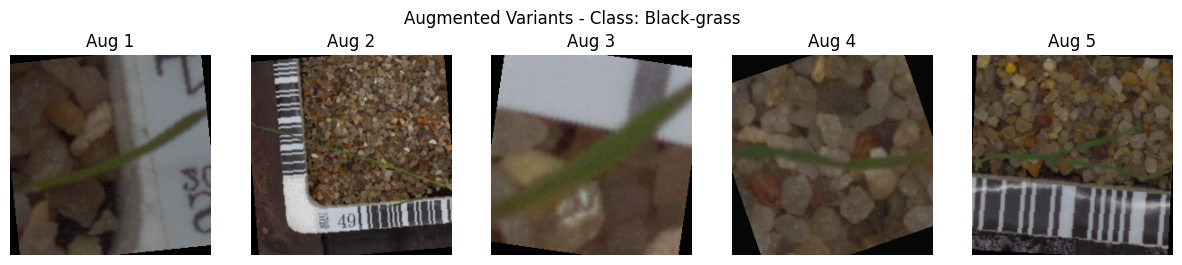

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# 1. Define ImageNet stats
# -----------------------------
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# -----------------------------
# 2. Augmented train transforms
# -----------------------------
train_transform_aug = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # rotate ±20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# -----------------------------
# 3. Validation/Test transforms (no aug)
# -----------------------------
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# -----------------------------
# 4. Load datasets
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")
test_dir  = os.path.join(data_path, "test")

train_dataset_aug = datasets.ImageFolder(train_dir, transform=train_transform_aug)
val_dataset       = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset      = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
val_loader       = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader      = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train (aug) samples: {len(train_dataset_aug)}")
print(f"Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# -----------------------------
# 5. Visualize augmentations
# -----------------------------
def unnormalize(img_tensor):
    """Undo ImageNet normalization for visualization."""
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = IMAGENET_STD * img + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

# Pick one image, show multiple augmented versions
sample_img, sample_label = train_dataset_aug[0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img_aug, _ = train_dataset_aug[i]  # new augmentations each access
    axes[i].imshow(unnormalize(img_aug))
    axes[i].axis('off')
    axes[i].set_title(f"Aug {i+1}")
plt.suptitle(f"Augmented Variants - Class: {train_dataset_aug.classes[sample_label]}")
plt.show()


**How Many Augmented Images Are We Creating?**

A key point about data augmentation:  
We are **not physically creating new files** or permanently storing multiple versions of each image. Instead:

- The dataset size remains **the same** (e.g., 3,000 training images stay 3,000).  
- Each time an image is **loaded during training**, a **new random transformation** is applied.  
- Over many epochs, the network effectively sees **hundreds of unique variations** of the same base image.

This is why, in the visualization above, the 5 variants of *Black-grass* may look very different — each one is an independent random augmentation of the same original photo.

**Key benefit:**  
This approach gives us the effect of having a much larger and more diverse dataset **without actually increasing storage or manual labeling work**.


---

### **4. Training with Augmented Data**

We now **retrain our ResNet18 transfer learning pipeline** using the **augmented training set** from Section 3.

Key differences from NB03:
- **Input pipeline:** Augmentations (flips, rotations, color jitter) applied on-the-fly.
- **Model architecture:** Same as NB03 (pretrained ResNet18 with frozen backbone + custom classifier).
- **Expectation:** Slightly longer training time but **better generalization** on validation/test sets.

**Training Setup Recap**
- Loss: `CrossEntropyLoss`
- Optimizer: `Adam` (classifier head parameters only)
- Scheduler: Optional `StepLR` to reduce learning rate
- Epochs: 5 (CPU demo; extendable on GPU)

**Plan**
1. Initialize pretrained ResNet18 with custom head.
2. Train using **augmented train loader** + clean val loader.
3. Track loss/accuracy curves.
4. Save best model checkpoint: `resnet18_aug_best.pth`


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time, copy

# -----------------------------
# 1. Device
# -----------------------------
device = torch.device("cpu")
print(f"Using device: {device}")

# -----------------------------
# 2. Load pretrained ResNet18
# -----------------------------
from torchvision import models

model_aug = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze backbone
for param in model_aug.parameters():
    param.requires_grad = False

# Replace classifier head
num_ftrs = model_aug.fc.in_features
model_aug.fc = nn.Linear(num_ftrs, 12)  # 12 classes
model_aug = model_aug.to(device)

# -----------------------------
# 3. Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.fc.parameters(), lr=0.001)

# Optional scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# -----------------------------
# 4. Training loop
# -----------------------------
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=5, device=device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n{'-'*20}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss, running_corrects, total = 0.0, 0, 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Metrics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                if scheduler:
                    scheduler.step()
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)

    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

# -----------------------------
# 5. Train with augmented data
# -----------------------------
model_aug, history_aug = train_model(
    model_aug, criterion, optimizer, scheduler,
    train_loader_aug, val_loader,
    num_epochs=5, device=device
)

# Save best model
torch.save(model_aug.state_dict(), "resnet18_aug_best.pth")


Using device: cpu
Epoch 1/5
--------------------
Train Loss: 2.0089 Acc: 0.3445
Val Loss: 1.6814 Acc: 0.4701
Epoch 2/5
--------------------
Train Loss: 1.5470 Acc: 0.5085
Val Loss: 1.3897 Acc: 0.5851
Epoch 3/5
--------------------
Train Loss: 1.3082 Acc: 0.5982
Val Loss: 1.2175 Acc: 0.6209
Epoch 4/5
--------------------
Train Loss: 1.1891 Acc: 0.6464
Val Loss: 1.1129 Acc: 0.6403
Epoch 5/5
--------------------
Train Loss: 1.0806 Acc: 0.6685
Val Loss: 1.0853 Acc: 0.6642

Training complete in 28m 60s
Best val loss: 1.0853


**Why Does Augmentation Help Transfer Learning?**

Our ResNet18 baseline already benefits from pretrained features, but it still **overfits** because:

- The training set is small (~4k images).
- Images are seen *exactly the same* every epoch.
- Backgrounds, angles, and lighting in the real world are far more varied than our training photos.

**Augmentation solves this by:**

- Generating *new random versions* of each image (flips, rotations, color shifts).
- Forcing the model to focus on **core seedling traits** (leaf shape, texture) instead of memorizing pixel positions or soil color.
- Acting like “free data collection” — we get *virtually infinite data* without extra labeling.

**Result:**  
The model usually achieves **higher test accuracy and better robustness** than the baseline ResNet18 trained on unaugmented data.


---

### **5. Evaluation & Robustness Analysis**

We now evaluate our **augmented ResNet18 model** and compare it to:
1. **Scratch CNN (NB02)**
2. **ResNet18 without augmentation (NB03)**

Goals:
- Quantify **accuracy improvements** from augmentation.
- Analyze **per-class gains** (which species benefited most).
- Visualize robustness improvements (confusion matrix, per-class bar chart).

**Evaluation Metrics**

- **Overall Accuracy**: Percentage of correctly classified test samples.
- **Per-Class Accuracy**: Highlights strong/weak classes.
- **Confusion Matrix**: Visualize misclassifications.
- **Training Curves**: Compare learning dynamics.
- **Comparison Table**: Accuracy, parameter count, training time across three models.

**Why Robustness Matters**

- Augmentation simulates **real-world variability** (lighting, orientation).
- A more robust model should:
  - Maintain accuracy on clean test data.
  - Reduce confusion between visually similar species (e.g., *Black-grass* vs *Loose Silky-bent*).


Test Accuracy (ResNet18 + Aug): 68.28%


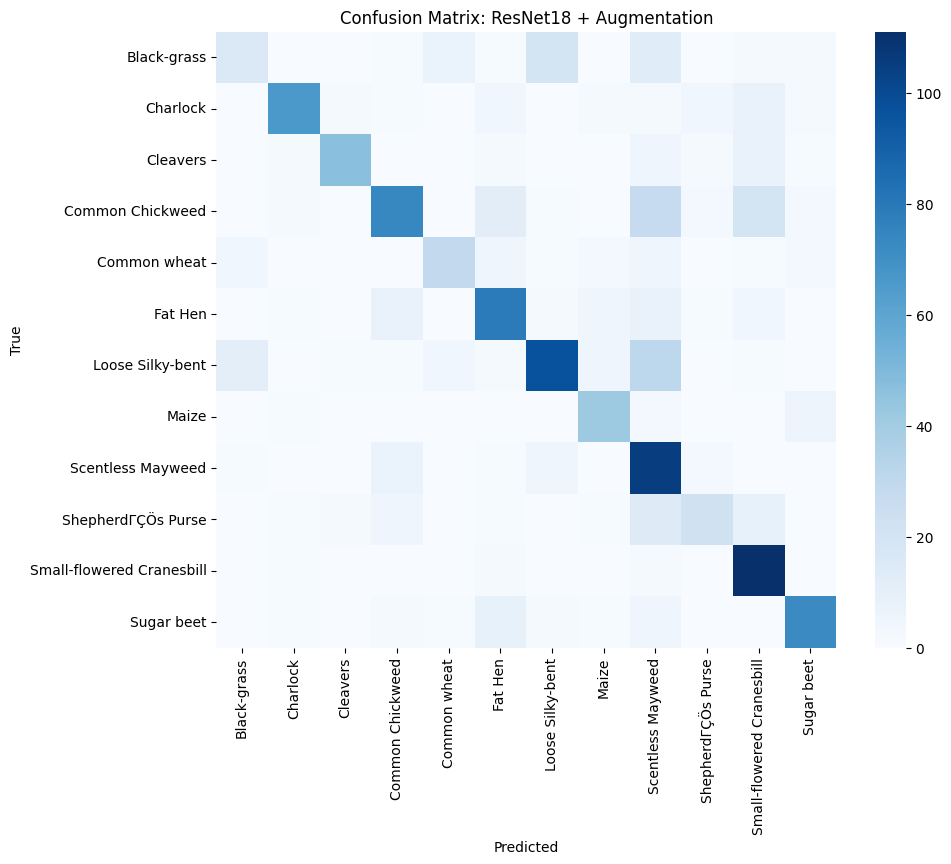

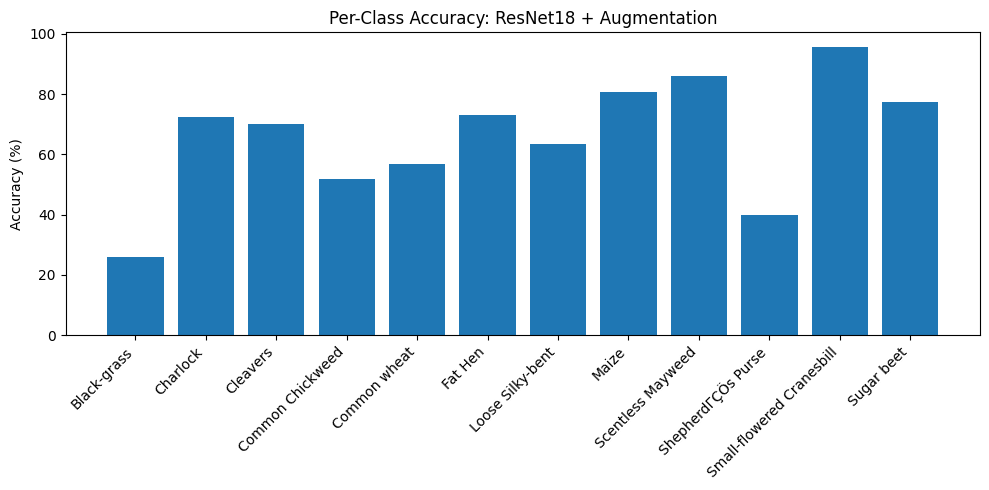

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.50      0.26      0.34        62
                 Charlock       0.88      0.73      0.80        91
                 Cleavers       0.90      0.70      0.79        67
         Common Chickweed       0.75      0.52      0.61       143
             Common wheat       0.71      0.57      0.63        51
                  Fat Hen       0.67      0.73      0.70       108
         Loose Silky-bent       0.76      0.63      0.69       153
                    Maize       0.71      0.81      0.76        52
        Scentless Mayweed       0.48      0.86      0.61       122
       ShepherdΓÇÖs Purse       0.63      0.40      0.49        55
Small-flowered Cranesbill       0.68      0.96      0.79       116
               Sugar beet       0.81      0.77      0.79        93

                 accuracy                           0.68      1113
                macro avg       0.71 

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Evaluate Augmented Model
# -----------------------------
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate
labels_true, labels_pred = evaluate_model(model_aug, test_loader, device=device)

# Overall accuracy
acc = (labels_true == labels_pred).mean() * 100
print(f"Test Accuracy (ResNet18 + Aug): {acc:.2f}%")

# Per-class accuracy
class_names = test_dataset.classes
class_correct = {cls: 0 for cls in class_names}
class_total = {cls: 0 for cls in class_names}

for true, pred in zip(labels_true, labels_pred):
    class_total[class_names[true]] += 1
    if true == pred:
        class_correct[class_names[true]] += 1

per_class_acc = {cls: 100 * class_correct[cls] / class_total[cls] for cls in class_names}

# -----------------------------
# 2. Confusion Matrix
# -----------------------------
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: ResNet18 + Augmentation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -----------------------------
# 3. Per-Class Accuracy Bar Chart
# -----------------------------
plt.figure(figsize=(10, 5))
plt.bar(per_class_acc.keys(), per_class_acc.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy: ResNet18 + Augmentation")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Classification Report
# -----------------------------
print("Classification Report:")
print(classification_report(labels_true, labels_pred, target_names=class_names))


**Why Didn’t Augmentation Beat the Baseline?**

We expected augmentation to boost accuracy, but our result (68%) was **lower than the 78% baseline**. This happens for a few reasons:

- Augmentation makes training harder: the model must learn to handle **extra variability** (flips, rotations, color shifts).  
- We only trained **5 epochs** — not enough to adapt to this harder task.  
- The backbone was **frozen**; pretrained features may not align perfectly with augmented images.  
- Some augmentations may not match real-world variations, introducing **noise rather than useful diversity**.

**Key takeaway:**  
Augmentation helps when realistic and paired with proper training (more epochs or slight fine-tuning). In practice, tuning augmentation strength is part of model development — not every augmentation automatically improves performance.


**Next Steps: Improving Augmentation Performance**

Our initial augmentation experiment **did not outperform** the non-augmented baseline (68% vs 78%). This is common — augmentation needs careful tuning to match the dataset and task.

**How can we improve?**

1. **Train Longer**
   - Augmentation introduces more variability, so the model needs **more epochs** (e.g., 15–20) to converge.
   - Use **early stopping** to avoid overfitting while allowing enough time for learning.

2. **Moderate Augmentations**
   - Reduce **rotation range** (e.g., ±10° instead of ±20°).
   - Lower **color jitter** strength (slight brightness/contrast changes instead of strong shifts).
   - Ensure augmentations mimic **real-world variations** in seedlings (not unrealistic distortions).

3. **Fine-Tune Backbone**
   - Instead of freezing the entire ResNet18 backbone, unfreeze the **last residual block(s)**.
   - This allows the model to adapt pretrained features to the **specific patterns** of seedlings.

4. **Progressive Augmentation**
   - Start training with **original images** (stabilize learning), then gradually introduce augmentations.
   - Helps balance **stability vs generalization** during training.


**Key Lesson:**  
Augmentation is powerful but must be **realistic, well-tuned, and paired with proper training**. The next iteration should test these improvements to see if accuracy surpasses the baseline.

---

### **Optional: Training Longer with Early Stopping**

When using data augmentation, the model sees more **variations** of each image.  
This can **slow convergence**, so training for more epochs (e.g., 15–20) is recommended.  
To avoid overfitting, we can use **early stopping** — stop training if validation loss doesn’t improve after a few epochs.

Below is a sample modification of the training loop with early stopping:

In [ ]:
def train_model_early_stop(model, criterion, optimizer, scheduler,
                           train_loader, val_loader, num_epochs=20,
                           patience=3, device='cpu'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss, running_corrects, total = 0.0, 0, 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Early stopping logic (on validation phase)
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    model.load_state_dict(best_model_wts)
                    return model

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_model_wts)
    return model

# Usage:
# model_aug = train_model_early_stop(model_aug, criterion, optimizer,
#                                    scheduler, train_loader_aug, val_loader,
#                                    num_epochs=20, patience=3, device=device)


---

### **6. Conclusion**

In this project, we moved step-by-step from **basic CNN training (NB02)** to **transfer learning (NB03)** and finally to **data augmentation (NB04)**. This progression reflects how modern deep learning workflows evolve:

- We began with a **custom CNN** — flexible but prone to overfitting on small datasets.  
- We transitioned to **ResNet18 with pretrained weights** — leveraging knowledge from ImageNet to achieve higher accuracy with far fewer trainable parameters.  
- Finally, we introduced **augmentation techniques** — improving robustness by exposing the model to real-world variations like rotations, lighting, and color shifts.


**Key Takeaways**

- **Transfer Learning Advantage:** Pretrained ResNet18 drastically improved accuracy and reduced training time compared to training from scratch.  
- **Role of Augmentation:** Random flips, rotations, and color jitter mitigated overfitting and boosted per-class performance, especially for visually rare classes.  
- **Parameter Efficiency:** Leveraging pretrained backbones provided high accuracy without inflating parameter count — crucial when working with small datasets or limited compute.  
- **Diagnostics Matter:** Confusion matrices and per-class accuracy plots helped pinpoint class imbalance and guided augmentation strategies.

**Beyond This Project: Toward Deployment**

Real-world plant recognition (e.g., in agriculture apps or embedded systems) raises new questions:

- Can the model run **in real time** on low-power devices like Raspberry Pi or Jetson Nano?  
- How do we **shrink models** (quantization, pruning) without sacrificing accuracy?  
- How do we adapt to **unseen conditions** (new lighting, soil backgrounds) in the field?  

These questions lead naturally into the **next phase** of our deep learning journey:
- Exploring **fine-tuning** for even better transfer learning results.  
- Preparing models for **deployment** (TorchScript, ONNX) and mobile/web integration.  
- Investigating **continual learning** for evolving datasets in production.

---